In [30]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

In [110]:
base_dirs = {
    "Without": Path("data/Without EDM"),
    "With": Path("data/With EDM")
}

dfs = []

for edm_state, dir_path in base_dirs.items():
    for file in sorted(dir_path.glob("G2_*.pkl")):
        run_id = int(file.stem.split("_")[1])
        with open(file, "rb") as f:
            X, Y, Z = pickle.load(f)
        
        df = pd.DataFrame({
            "lambda_frac": X.ravel(),
            "theta_mrad": (Y * 1000).ravel(),
            "prob_density": Z.ravel(),
            "run_id": run_id,
            "edm_state": edm_state
        })
        dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

In [111]:
output_base = Path("outputs")
save = False

if save:
    for edm_state in tqdm(["With", "Without"], desc="EDM States"):
        # Match the folder names on disk
        folder_name = "With EDM" if edm_state == "With" else "Without EDM"
        output_dir = output_base / folder_name
        output_dir.mkdir(parents=True, exist_ok=True)

        for run_id in range(29):
            subset = df_all.query("edm_state == @edm_state and run_id == @run_id")
            if subset.empty:
                print(f"Skipping {edm_state} run {run_id:02} — no data found.")
                continue

            # Get unique sorted axes
            lambdas = np.sort(subset["lambda_frac"].unique())
            thetas = np.sort(subset["theta_mrad"].unique())

            # Reshape back into 2D grid
            Z_grid = subset.pivot_table(
                index="theta_mrad",
                columns="lambda_frac",
                values="prob_density"
            ).values

            # File name format
            if edm_state == "With":
                fname = f"G2_{run_id:02}_withEDM_heatmap.png"
            else:
                fname = f"G2_{run_id:02}_heatmap.png"

            save_path = output_dir / fname

            # Plot and save with no inline output
            plt.figure(figsize=(6,6))
            plt.imshow(
                Z_grid,
                extent=[lambdas.min(), lambdas.max(), thetas.min(), thetas.max()],
                aspect='auto',
                origin='lower',
                cmap='viridis'
            )
            plt.xlabel(r"Fractional energy ($\lambda$)")
            plt.ylabel(r"Longitudinal angle ($\theta_L$) [mrad]")
            plt.title(f"{folder_name} — Run {run_id:02}")
            plt.colorbar(label="Probability density")
            plt.tight_layout()
            plt.savefig(save_path, dpi=200)
            plt.close()

            print(f"Saved: {save_path.resolve()}")
else:
    print("Files already saved.")


Files already saved.


In [112]:
dftemp = df_all.query("edm_state == 'With' and run_id == 0 and lambda_frac==0.2")
dftemp.reset_index(drop=True, inplace=True)
dtheta = np.fabs(dftemp["theta_mrad"].loc[0] - dftemp["theta_mrad"].loc[1])

dftemp_theta = df_all.query("edm_state == 'With' and run_id == 0 and theta_mrad==200.0")
dftemp_theta.reset_index(drop=True, inplace=True)
dlambda = np.fabs(dftemp_theta["lambda_frac"].loc[0] - dftemp_theta["lambda_frac"].loc[1])

#for i in range(29):
#    dftemp = df_all.query(f"edm_state == 'With' and run_id == {i}")
#    print(i, dftemp["prob_density"].sum() * dtheta * dlambda * 1e-3)


generate_n = False
if generate_n:
    n_vals = [1, 10, 100, 1000, 2500, 5000, 7500, 10000]
else:
    n_vals=[10000]

steps = 5
lambda_values = np.linspace(0.2,0.95,steps)

metrics = {}

def CalculateMetrics(g, n):
    probs = n * g["prob_density"] * 1e-3
    theta = g["theta_mrad"]
    w_mean = np.sum(theta * probs) / np.sum(probs)
    w_var = np.sum(probs * theta**2) / np.sum(probs) - w_mean**2
    w_sem = np.sqrt(w_var) / np.sqrt(np.sum(probs))
    return pd.Series({"mean": w_mean, "wsig":np.sqrt(w_var), "sem": w_sem})

plotting = False
for n_curr in n_vals:
    all_metrics = []
    for lambda_curr in lambda_values:
        closest_idx = (df_all["lambda_frac"] - lambda_curr).abs().idxmin()
        closest_lambda = df_all.loc[closest_idx, "lambda_frac"]
        subset = df_all[df_all["lambda_frac"] == closest_lambda]
        results = (
        subset
        .groupby(["edm_state", "run_id"])
        .apply( lambda g: CalculateMetrics(g,n_curr),include_groups=False)
        )

        angles = results.unstack("edm_state")

        means = results["mean"].unstack("edm_state")
        stddev = results["wsig"].unstack("edm_state")
        errors = results["sem"].unstack("edm_state")
        FOM = np.sum(means["With"]**2 / (2 * errors["With"]**2))
        all_metrics.append({
            "lambda_frac": lambda_curr,
            "FOM": FOM
        })
        if plotting:
            plt.figure(figsize=(7,5))
            plt.title(fr"$\lambda$={lambda_curr}")
            plt.errorbar(means.index, means["With"], yerr=errors["With"], fmt="o-", label="With EDM")
            plt.errorbar(means.index, means["Without"], yerr=errors["Without"], fmt="s--", label="Without EDM")
            plt.xlabel("Run ID")
            plt.ylabel(r"$\langle\theta\rangle$ [mrad]")
            plt.legend()
            plt.grid(True)
            plt.show()
    metrics[n_curr] = pd.DataFrame(all_metrics)


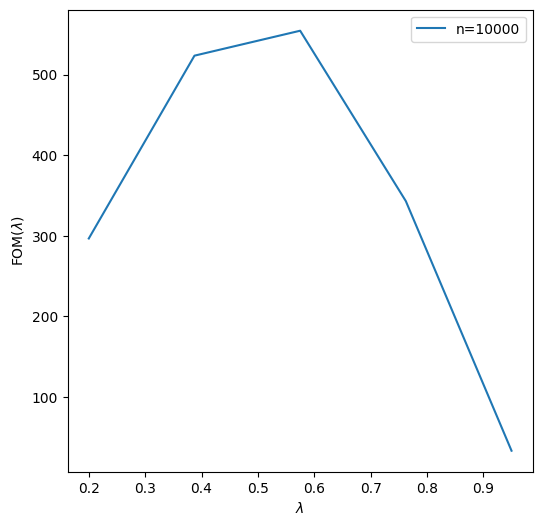

In [113]:
fig = plt.figure(figsize=(6,6))
for n_curr in n_vals:
    plt.plot(metrics[n_curr]["lambda_frac"],metrics[n_curr]["FOM"],label=f"n={n_curr}")

plt.xlabel(r"$\lambda$")
plt.ylabel(r"FOM($\lambda$)")
plt.legend()
plt.show()

In [114]:
df_grid = df_all.query("edm_state=='With' and run_id == 7").pivot_table(
    index="theta_mrad",
    columns="lambda_frac",
    values="prob_density"
)

theta_vals = df_grid.index.values
lambda_vals = df_grid.columns.values

TH, LAM = np.meshgrid(theta_vals, lambda_vals, indexing='ij')

weights_dict = {
    "Uniform 1s" : np.ones_like(TH),
    "Uniform 5s" : 5*np.ones_like(TH),
    "Central energy" : np.exp(-((LAM / 10)**2)),
    "Edge energy" : 1 - np.exp(-((LAM / 10)**2)),
    "Cental theta" : np.exp(-((TH / 10)**2)),
    "Edge theta" : 1 - np.exp(-((TH / 100)**2)),
    "Small angle, large energy": np.exp(-((TH / 100)**2)) * LAM,
    "Large angle, small energy": (1-np.exp(-((TH / 100)**2))) * LAM,
}

weights_df = pd.DataFrame({
    "theta_mrad": TH.ravel(),
    "lambda_frac": LAM.ravel(),
    **{name: w.ravel() for name, w in weights_dict.items()}
})

plotting = False
if plotting:
    for name, w in weights_dict.items():
        weighted = df_grid.values * w
        print(df_grid.values.shape, w.shape)
        plt.figure()
        plt.pcolormesh(lambda_vals, theta_vals, weighted, shading='auto')
        plt.title(name)
        plt.xlabel(r"$\lambda$ (energy fraction)")
        plt.ylabel(r"$\theta$ (mrad)")
        plt.colorbar(label="Weighted prob. density")
        plt.savefig(f"outputs/Weighting/{name}.png")
        plt.show()
else:
    print("Plotting disabled")

Plotting disabled


In [119]:
def CalculateWeightedMetrics(g, w, N):
    probs = N * g["prob_density"] * 1e-3
    theta = g["theta_mrad"]

    w = np.abs(w)

    n = np.sum(probs*w)

    neff = np.sum(probs*w)**2 / np.sum(probs*w**2)
    
    mean = np.sum(w*probs*theta) / n
    var = np.sum(probs * w * (theta - mean)**2) / n * (neff / (neff-1))
    sig = np.sqrt(var)
    sem = sig/np.sqrt(neff)
    
    return pd.Series({"mean": mean, "wsig":np.sqrt(var), "sem": sem})

In [ ]:
lambda_values = [0.5]
n_curr=10000

for name, w in weights_dict.items():
    all_metrics = []
    for lambda_curr in lambda_values:
        closest_idx = (df_all["lambda_frac"] - lambda_curr).abs().idxmin()
        closest_lambda = df_all.loc[closest_idx, "lambda_frac"]
        subset = df_all[df_all["lambda_frac"] == closest_lambda]

        weight_subset = weights_df[["theta_mrad", "lambda_frac", name]]
        subset = subset.merge(weight_subset, on=["theta_mrad", "lambda_frac"], how="left")
        print(subset[name].info)

        results = (
        subset
        .groupby(["edm_state", "run_id"])
        .apply( lambda g: CalculateWeightedMetrics(g,subset[name],n_curr),include_groups=False)
        )

        angles = results.unstack("edm_state")

        means = results["mean"].unstack("edm_state")
        stddev = results["wsig"].unstack("edm_state")
        errors = results["sem"].unstack("edm_state")
        FOM = np.sum(means["With"]**2 / (2 * errors["With"]**2))
        all_metrics.append({
            "lambda_frac": lambda_curr,
            "FOM": FOM
        })
        plotting = False
        if plotting:
            plt.figure(figsize=(7,5))
            plt.title(fr"$\lambda$={lambda_curr}")
            plt.errorbar(means.index, means["With"], yerr=errors["With"], fmt="o-", label="With EDM")
            plt.errorbar(means.index, means["Without"], yerr=errors["Without"], fmt="s--", label="Without EDM")
            plt.xlabel("Run ID")
            plt.ylabel(r"$\langle\theta\rangle$ [mrad]")
            plt.legend()
            plt.grid(True)
            plt.show()
    metrics[name] = pd.DataFrame(all_metrics)

<bound method Series.info of 0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
28995    1.0
28996    1.0
28997    1.0
28998    1.0
28999    1.0
Name: Uniform 1s, Length: 29000, dtype: float64>
291.8327962254537
291.7658956205362
291.5751349965107
291.28930996152025
290.95294162480127
290.62096242563797
290.3512483898951
290.19538098370447
290.1886324129294
290.34094125898395
290.6313066383228
291.0081378470509
291.39720081661136
291.7167543965787
291.8967521529391
291.8967521542698
291.7167544028115
291.39720083377495
291.00813788310404
290.6313067007143
290.34094135233266
290.18863253741216
290.1953811344575
290.3512485574362
290.6209625970932
290.95294178560897
291.28931009728643
291.5751350947438
291.7658956720719
291.83279622545376
291.83367458591965
291.83628576827203
291.8405568159327
291.8463621732708
291.85351859745606
291.86177981676894
291.87083282919167
291.88029827956234
291.8897376369509
291.89866962268366
291.90659721953233
291.9130445027656
29

Uniform 1s, 571
Uniform 5s, 571
Central energy, 571
Edge energy, 571
Cental theta, 94.9
Edge theta, 749
Small angle, large energy, 550
Large angle, small energy, 749


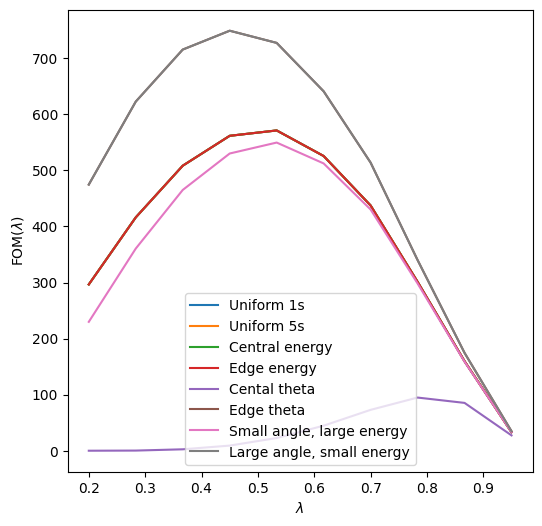

In [44]:
fig = plt.figure(figsize=(6,6))
for name, w in weights_dict.items():
    print(f"{name}, {metrics[name]['FOM'].max():.3g}")
    plt.plot(metrics[name]["lambda_frac"],metrics[name]["FOM"],label=f"{name}")

plt.xlabel(r"$\lambda$")
plt.ylabel(r"FOM($\lambda$)")
plt.legend()
plt.show()

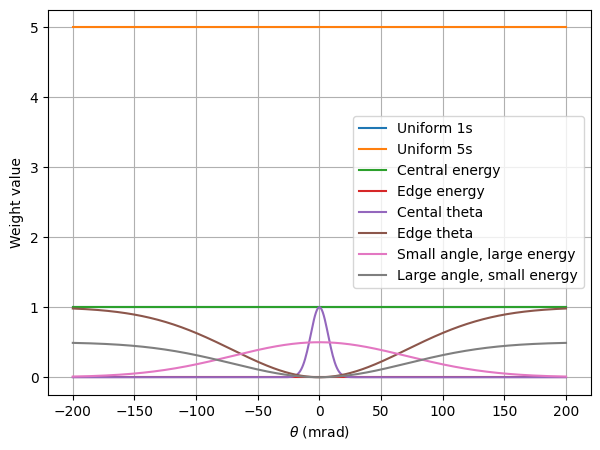

In [38]:
lambda_target = 0.5
closest_lambda = weights_df["lambda_frac"].iloc[(weights_df["lambda_frac"] - lambda_target).abs().idxmin()]
slice_df = weights_df.query("lambda_frac == @closest_lambda")

plt.figure(figsize=(7,5))
for name in weights_dict.keys():
    plt.plot(slice_df["theta_mrad"], slice_df[name], label=name)

plt.xlabel(r"$\theta$ (mrad)")
plt.ylabel("Weight value")
plt.legend()
plt.grid(True)
plt.show()


In [46]:
df_pivot = df_all.pivot_table(
    index=["theta_mrad", "lambda_frac", "run_id"],
    columns="edm_state",
    values="prob_density"
)

df_pivot["diff"] = df_pivot["With"] - df_pivot["Without"]
df_diff = df_pivot.reset_index()[["theta_mrad", "lambda_frac", "run_id", "diff"]]

plotting=False
for i in range(29):
    df_diff_i = df_diff.query("run_id == @i").pivot_table(
        index="theta_mrad", columns="lambda_frac", values="diff"
    )
    if plotting==True:
        plt.figure(figsize=(6,5))
        plt.pcolormesh(df_diff_i.columns, df_diff_i.index, df_diff_i.values, shading="auto", cmap="coolwarm")
        plt.xlabel("$\lambda$ (energy fraction)")
        plt.ylabel(r"$\theta$ [mrad]")
        plt.title(fr"$\Delta$ Probability Density (With - Without EDM) for Run = {i:02}")
        plt.colorbar(label="Difference")
        plt.savefig(f"outputs/Difference/Difference {i:02}")
        plt.show()


(500, 500) (500, 500)


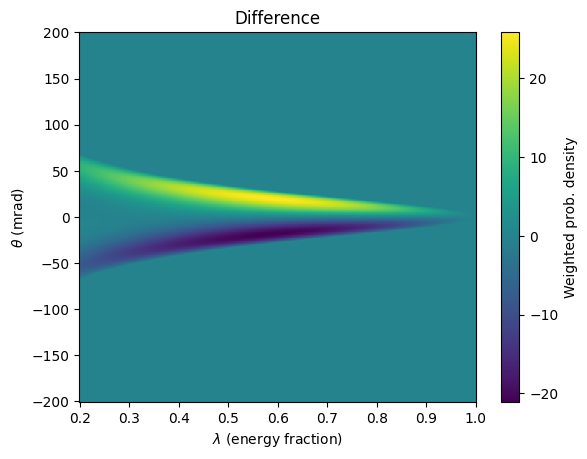

In [115]:
temp_df = df_diff.query("run_id == 7").pivot_table(
    index="theta_mrad", columns="lambda_frac", values="diff"
)

weights_df["Difference"] = temp_df.values.ravel()
weights_dict["Difference"] = temp_df.values

name="Difference"
for name, w in weights_dict.items():
    if name == "Difference":
        weighted = df_grid.values * w
        print(df_grid.values.shape, w.shape)
        plt.figure()
        plt.pcolormesh(lambda_vals, theta_vals, weighted, shading='auto')
        plt.title(name)
        plt.xlabel(r"$\lambda$ (energy fraction)")
        plt.ylabel(r"$\theta$ (mrad)")
        plt.colorbar(label="Weighted prob. density")
        plt.savefig(f"outputs/Weighting/{name}.png")
        plt.show()

In [126]:
def FOM(lambda_curr = 0.5,name="Uniform 1s",w=0):
    tmp_df = weights_df.copy()
    try:
        weight_subset = tmp_df[["theta_mrad", "lambda_frac", name]]
    except KeyError:
        if w.size==250000:
            tmp_df[name] = w
            weight_subset = tmp_df[["theta_mrad", "lambda_frac", name]]
        else:
            return f"{name} not found."


    closest_idx = (df_all["lambda_frac"] - lambda_curr).abs().idxmin()
    closest_lambda = df_all.loc[closest_idx, "lambda_frac"]
    subset = df_all[df_all["lambda_frac"] == closest_lambda]

    
    subset = subset.merge(weight_subset, on=["theta_mrad", "lambda_frac"], how="left")

    results = (
    subset
    .groupby(["edm_state", "run_id"])
    .apply( lambda g: CalculateWeightedMetrics(g,subset[name],10000),include_groups=False)
    )

    angles = results.unstack("edm_state")

    means = results["mean"].unstack("edm_state")
    stddev = results["wsig"].unstack("edm_state")
    errors = results["sem"].unstack("edm_state")
    FOM = np.sum(means["With"]**2 / (2 * errors["With"]**2))
    return FOM

FOM(0.5,"Differenceasdf",temp_df.values.ravel())

699.3186050238717

In [121]:
weights_df.head()

,theta_mrad,lambda_frac,Uniform 1s,Uniform 5s,Central energy,Edge energy,Cental theta,Edge theta,"Small angle, large energy","Large angle, small energy",Difference
0,-200.0,0.200000,1.0,5.0,0.999600,0.000400,1.915170e-174,0.981684,0.003663,0.196337,0.0
1,-200.0,0.201603,1.0,5.0,0.999594,0.000406,1.915170e-174,0.981684,0.003692,0.197911,0.0
2,-200.0,0.203206,1.0,5.0,0.999587,0.000413,1.915170e-174,0.981684,0.003722,0.199485,0.0
3,-200.0,0.204810,1.0,5.0,0.999581,0.000419,1.915170e-174,0.981684,0.003751,0.201058,0.0
4,-200.0,0.206413,1.0,5.0,0.999574,0.000426,1.915170e-174,0.981684,0.003781,0.202632,0.0
